In [35]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import pandas as pd
from math import sqrt

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,confusion_matrix
import pydot

# Random Forest Model
Adaptation from: Will Koehrsen

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

## Getting, exploring, and prepping data

In [19]:
# get iris
# Read in data and display first 5 rows
iris = datasets.load_iris()

pd.DataFrame(iris.data, columns=iris.feature_names).head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


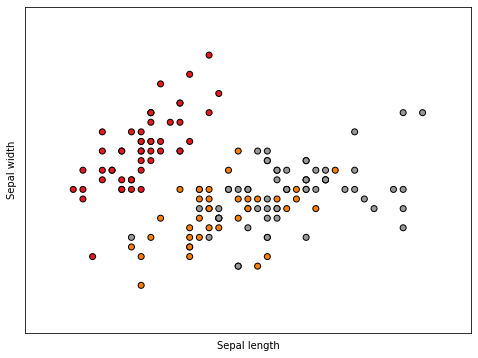

In [20]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

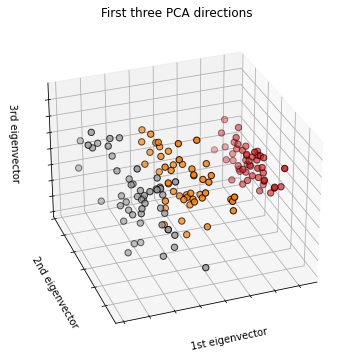

In [21]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()


In [22]:
iris_meas = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_spec = pd.DataFrame(iris.target, columns=['species'])

iris = pd.concat([iris_meas, iris_spec], axis=1)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [23]:
# Descriptive statistics for each column
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [24]:
# One-hot encode the data using pandas get_dummies
iris = pd.get_dummies(iris) 
# Display the first 5 rows of the last 12 columns
iris.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [25]:
# Labels are the values we want to predict
labels = np.array(iris['species'])# Remove the labels from the features
# axis 1 refers to the columns
iris = iris.drop('species', axis = 1) # Saving feature names for later use
meas_list = list(iris.columns) # Convert to numpy array
iris = np.array(iris)
iris

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

## Prep and run Random Forest

In [26]:
# Split the data into training and testing sets
train_meas, test_meas, train_labels, test_labels = train_test_split(
    iris, labels, test_size = 0.33, random_state = 42
    )

In [27]:
print('Training Measures Shape:', train_meas.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Measures Shape:', test_meas.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Measures Shape: (100, 4)
Training Labels Shape: (100,)
Testing Measures Shape: (50, 4)
Testing Labels Shape: (50,)


In [28]:
# The baseline predictions are the historical averages
baseline_preds = test_meas[:, int(np.average(labels))] 
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print(f'Average baseline error: {round(np.mean(baseline_errors), 2)} degrees.')

Average baseline error: 2.21 degrees.


### Training the model

In [29]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_meas, train_labels);

### Making predictions

In [30]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_meas)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.02 degrees.


In [31]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.average(test_labels))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.42 %.


#### Attempt at visualizing

In [32]:
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Pull out one tree from the forest
# tree = rf.estimators_[5]# Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = meas_list, rounded = True, precision = 1)# Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('tree.png')

## Analysis

Our accuracy is 97.42%! Given the improvement in the model, we can conclude there accurate species predictions. This can help botanists distinguish their irises quickly and accurately. Potentially meeting their needs sooner and saving time, money, and increasing profit if they are sold.

# Neural Network
From: https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn

Using same training/testing data

## Training and testing model

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(train_meas,train_labels)

predict_train = mlp.predict(train_meas)
predict_test = mlp.predict(test_meas)

print(confusion_matrix(train_labels,predict_train))
print(classification_report(train_labels,predict_train))

[[31  0  0]
 [ 0 34  1]
 [ 0  0 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      0.97      0.99        35
           2       0.97      1.00      0.99        34

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



The above output shows the performance of the model on training data. The accuracy and the F1 score is 1, .94, and .94, respectively. This dataset is highly tailored, most real world datasets will see an ideal .75 or so. The goal is to be as close to 1 as possible. :)

### Evaluate performance

In [37]:
print(confusion_matrix(test_labels, predict_test))
print(classification_report(test_labels, predict_test))

[[19  0  0]
 [ 0 15  0]
 [ 0  1 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



The above output shows the performance of the model on test data. The accuracy and F1 scores both around 1, which is ideal. 

## Analysis

Our model is achieving a decent accuracy of 99% and 98% on training and test data, respectively. This can help botanists distinguish their irises quickly and accurately. Potentially meeting their needs sooner and saving time, money, and increasing profit if they are sold.

# Model comparison

Both are highly accurate with this dataset. Given the high degree of accuracy as displayed in the confusion matrix, neural networks will be our best bet.

We can rely on these results to correctly identify the species of iris. These results can help botanists make informed decisions to provide great care to the plants